In [1]:
import cv2
from keras.layers import Input, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Add, concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model,load_model
from tensorflow.keras.optimizers import RMSprop
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import glob
from matplotlib import pyplot as plt
import tensorflow as tf
import math
relu = tf.keras.layers.ReLU()

In [2]:
from PIL import Image
filelist = glob.glob('../Dataset/*')
images = np.array([np.array(Image.open(fname)) for fname in filelist])

In [3]:
images.shape

(1836, 240, 240, 3)

In [4]:
images = (images-np.min(images))/(np.max(images)-np.min(images))

In [5]:
np.max(images)

1.0

In [6]:
input_img = Input(shape = (240,240,3))
train_X,valid_X,train_ground,valid_ground = train_test_split(images,images,test_size=0.2,random_state=42)

In [7]:
def DCRBlock(features,kernelsize):
    c1 = Conv2D(kernelsize*1.5,(3,3),activation='relu',padding='same')(features)
    c1 = BatchNormalization()(c1)

    conca1 = concatenate([features,c1])
    
    c2 = Conv2D(kernelsize*2,(3,3),activation='relu',padding='same')(conca1)
    c2 = BatchNormalization()(c2)

    conca2 = concatenate([features,conca1,c2])
    
    c3 = Conv2D(kernelsize,(3,3),activation='relu',padding='same')(conca2)
    c3 = BatchNormalization()(c3)

    ress = Add()([features,c3])

    return ress

In [12]:
def CNNwithDCR(input_img,kernelsize):
    conv1 = Conv2D(kernelsize, (3, 3), activation='relu', padding='same')(input_img)
    
    dcr1 = DCRBlock(conv1,kernelsize)

    dcr2 = DCRBlock(dcr1,kernelsize)

    dcr3 = DCRBlock(dcr2,kernelsize)

    dcr4 = DCRBlock(dcr3,kernelsize)

    dcr5 = DCRBlock(dcr4,kernelsize)

    dcr6 = DCRBlock(dcr5,kernelsize)

    dcr7 = DCRBlock(dcr6,kernelsize)

    dcr8 = DCRBlock(dcr7,kernelsize)

    convfinal = Conv2D(1,1,activation='sigmoid',padding='same')(dcr8)

    ress = Add()([input_img,convfinal])
    return convfinal




In [13]:
opt = RMSprop(learning_rate=1e-3)
autoencoder = Model(input_img, CNNwithDCR(input_img,64))
autoencoder.compile(loss='mean_squared_error', optimizer = opt)

In [14]:
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 240, 240, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_27 (Conv2D)             (None, 240, 240, 96  55392       ['conv2d_26[0][0]']              
                                )                                                           

In [ ]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=32,epochs=5,verbose=1,validation_data=(valid_X, valid_ground))
autoencoder.save("DCRBlock3epoch2",save_format="h5")

In [ ]:
autoencoder = load_model('DCRBlock3epoch2')
pred = autoencoder.predict(valid_X)

Test Images


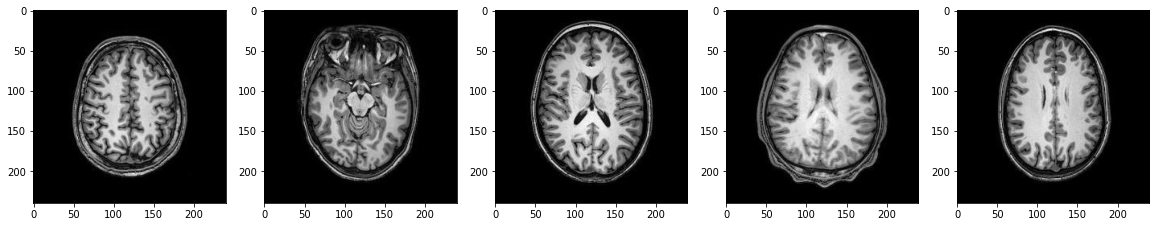

Reconstruction of Test Images


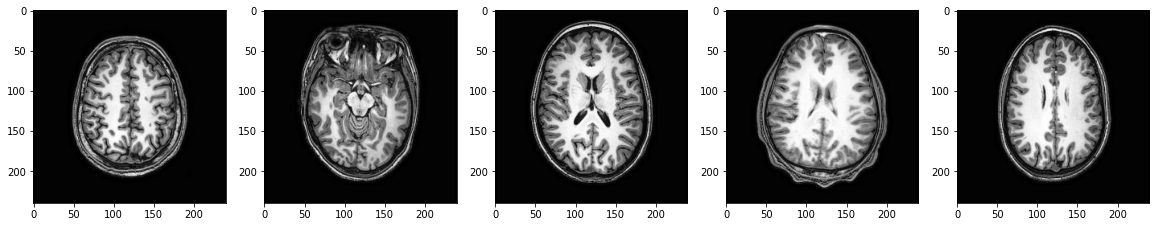

In [25]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [26]:
autoencoder.save("DCRBlock3epoch2",save_format="h5")

In [11]:
autoencoder = load_model('DCRBlock3epoch2')
pred = autoencoder.predict(valid_X)

In [14]:
mse = np.mean((pred - valid_X)**2)
psnr_inputimage = 20 * math.log10(1/math.sqrt(mse))

In [15]:
print("PSNR of the reconstructed image",psnr_inputimage)

PSNR of the reconstructed image 31.646651000777815


In [16]:
[a,b,c,d]= np.shape(valid_X)
mean = 0
sigma = 0.05
gauss = np.random.normal(mean,sigma,(a,b,c,d))
noisy_images = valid_X + gauss

In [17]:
pred_noisy = autoencoder.predict(noisy_images)

Noisy Test Images


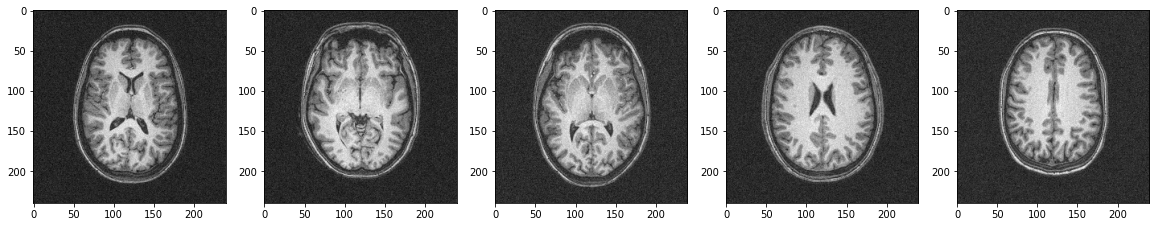

Reconstruction of Noisy Test Images


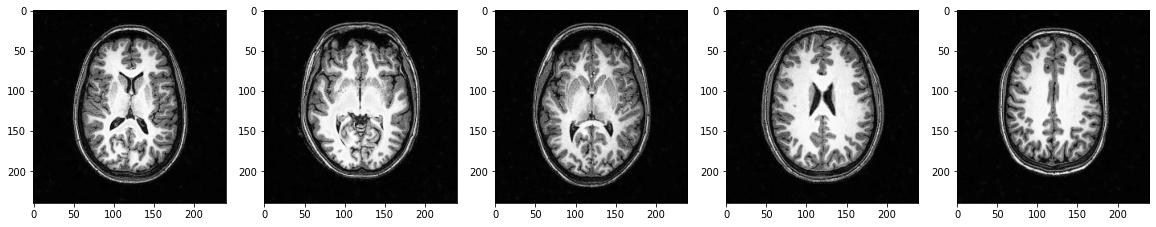

In [30]:
plt.figure(figsize=(20, 4))
print("Noisy Test Images")
for i in range(12,17):
    plt.subplot(1, 5, i+1 - 12)
    plt.imshow(noisy_images[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(12,17):
    plt.subplot(1, 5, i+1 -12)
    plt.imshow(pred_noisy[i, ..., 0], cmap='gray')  
plt.show()

In [31]:
mse = np.mean((noisy_images - valid_X)**2)
psnr_inputimage = 20 * math.log10(1/math.sqrt(mse))

In [32]:
print("PSNR of the input noisy image",psnr_inputimage)

PSNR of the input noisy image 26.020047139184896


In [33]:
mse = np.mean((pred_noisy-valid_X)**2)
psnr_inputimage = 20 * math.log10(1/math.sqrt(mse))

In [34]:
print("PSNR of the reconstructed image",psnr_inputimage)

PSNR of the reconstructed image 29.688599140369956


In [36]:
for layer in autoencoder.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d_11 (3, 3, 3, 64)
conv2d_12 (3, 3, 64, 96)
conv2d_13 (3, 3, 160, 128)
conv2d_14 (3, 3, 352, 64)
conv2d_15 (3, 3, 64, 96)
conv2d_16 (3, 3, 160, 128)
conv2d_17 (3, 3, 352, 64)
conv2d_18 (3, 3, 64, 96)
conv2d_19 (3, 3, 160, 128)
conv2d_20 (3, 3, 352, 64)
conv2d_21 (1, 1, 64, 1)


In [37]:
filters , bias = autoencoder.layers[1].get_weights()

In [39]:
print(filters,bias)

[[[[ 5.04197218e-02  4.22761776e-02 -4.26848605e-03 ... -1.78219248e-02
     8.67009684e-02  1.53589234e-01]
   [-5.83699271e-02  8.89079832e-03  9.62655991e-02 ...  2.73408499e-02
     7.60086402e-02  8.22206736e-02]
   [-1.57410428e-02  8.76604915e-02  1.05382249e-01 ... -4.06387821e-02
     1.12792931e-01  1.20790571e-01]]

  [[-1.85872838e-02  1.58455484e-02 -6.88655451e-02 ...  1.19029708e-01
     4.86738794e-02  3.06690354e-02]
   [ 4.25247289e-02 -2.03372678e-04  3.33448872e-02 ...  4.68841828e-02
     8.47619548e-02  4.62299660e-02]
   [ 3.98344174e-02 -1.05781145e-01  9.22333673e-02 ... -4.58905958e-02
    -4.39591072e-02  1.15558006e-01]]

  [[-1.29079223e-01 -5.14357910e-02 -1.15958191e-01 ...  7.91318193e-02
     1.10062867e-01  9.24845710e-02]
   [-3.76997553e-02 -1.52035048e-02 -8.52771327e-02 ... -3.75472419e-02
     6.76617622e-02  1.09323271e-01]
   [-4.25612256e-02  2.88161524e-02 -9.67362151e-02 ... -5.55766337e-02
     6.49966896e-02 -3.35390447e-03]]]


 [[[ 1.2174

In [40]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

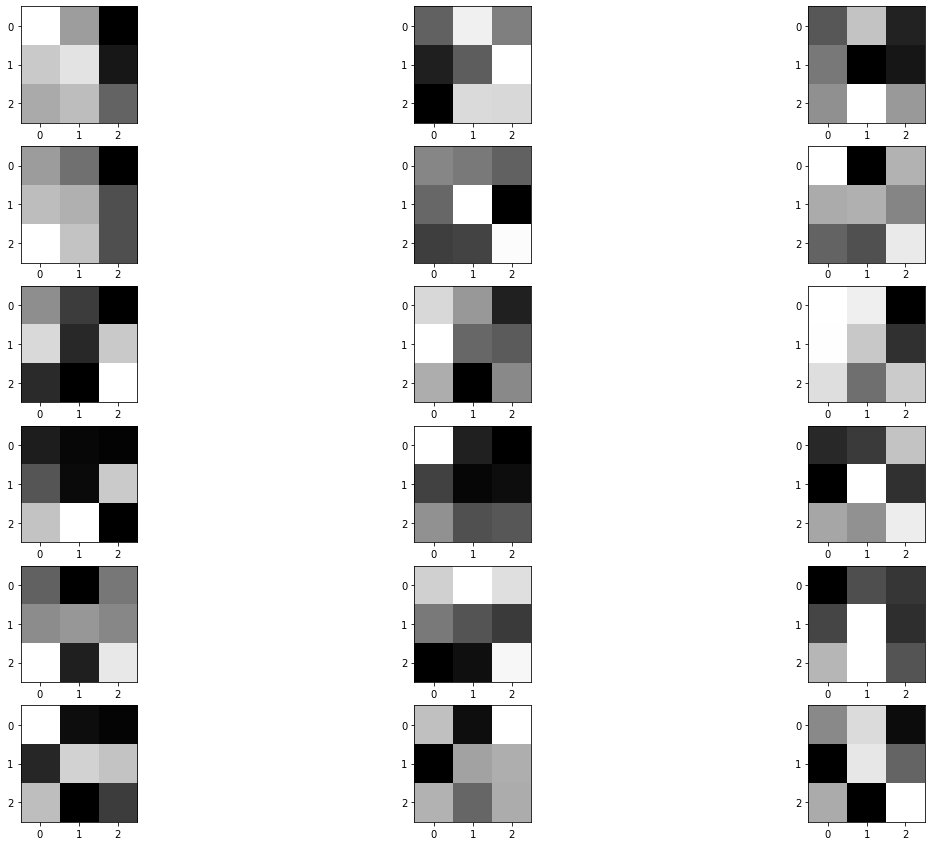

In [45]:
n_filters =6
ix=1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
plt.show()

In [47]:
for i in range(len(autoencoder.layers)):
    layer = autoencoder.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

1 conv2d_11 (None, 240, 240, 64)
2 conv2d_12 (None, 240, 240, 96)
5 conv2d_13 (None, 240, 240, 128)
8 conv2d_14 (None, 240, 240, 64)
11 conv2d_15 (None, 240, 240, 96)
14 conv2d_16 (None, 240, 240, 128)
17 conv2d_17 (None, 240, 240, 64)
20 conv2d_18 (None, 240, 240, 96)
23 conv2d_19 (None, 240, 240, 128)
26 conv2d_20 (None, 240, 240, 64)
29 conv2d_21 (None, 240, 240, 1)
